In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [5]:
# === Step 2: Load NVIDIA Stock Data ===
df = pd.read_csv("/content/nvidia_stock_cleaned.csv")
df.head(10)



,date,open,high,low,close,adjclose,volume
0,2015-01-02,0.50325,0.50700,0.49525,0.50325,0.483218,113680000
1,2015-01-05,0.50325,0.50475,0.49250,0.49475,0.475056,197952000
2,2015-01-06,0.49550,0.49600,0.47925,0.47975,0.460654,197764000
3,2015-01-07,0.48325,0.48750,0.47700,0.47850,0.459453,321808000
4,2015-01-08,0.48400,0.49950,0.48375,0.49650,0.476737,283780000
5,2015-01-09,0.49825,0.50225,0.49150,0.49850,0.478657,209540000
6,2015-01-12,0.49975,0.50000,0.48775,0.49225,0.472656,190732000
7,2015-01-13,0.49600,0.50600,0.48800,0.49150,0.471936,236720000
8,2015-01-14,0.48625,0.49500,0.48500,0.49350,0.473856,155260000
9,2015-01-15,0.49700,0.50000,0.48975,0.49000,0.470496,188932000


In [6]:
df.isnull().sum()


,0
date,0
open,0
high,0
low,0
close,0
adjclose,0
volume,0


In [7]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df[['close']].dropna()
df.columns = ['Close']
df.head(10)


,Close
date,
2015-01-02,0.50325
2015-01-05,0.49475
2015-01-06,0.47975
2015-01-07,0.47850
2015-01-08,0.49650
2015-01-09,0.49850
2015-01-12,0.49225
2015-01-13,0.49150
2015-01-14,0.49350


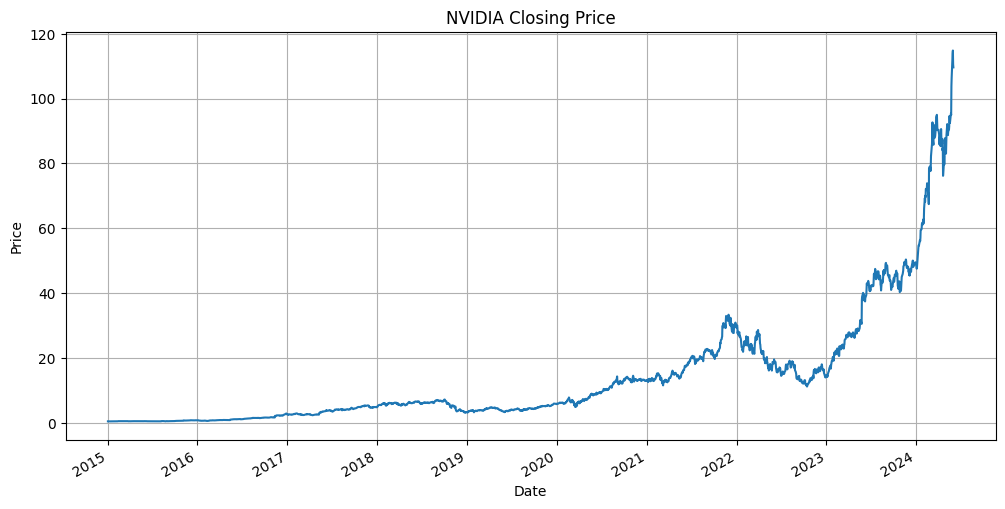

In [8]:
# === Step 3: Visualization ===
plt.figure(figsize=(12, 6))
df['Close'].plot(title='NVIDIA Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


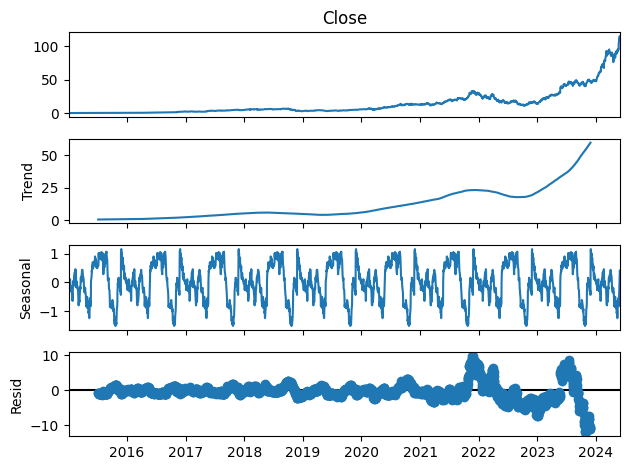

In [9]:
# === Step 4: Seasonal Decomposition ===
decompose = seasonal_decompose(df['Close'], model='additive', period=252)
decompose.plot()
plt.show()


In [10]:
# === Step 7: LSTM ===
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

train_size = int(len(df_scaled) * 0.85)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Create sequences
def create_dataset(dataset, time_step=90):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(90, 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1, validation_data=(X_test, y_test))

lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 2/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 1.3387e-04 - val_loss: 0.0057
Epoch 3/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 1.4869e-04 - val_loss: 0.0038
Epoch 4/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 1.0439e-04 - val_loss: 0.0032
Epoch 5/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 1.1764e-04 - val_loss: 0.0040
Epoch 6/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 9.0794e-05 - val_loss: 0.0041
Epoch 7/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 8.8709e-05 - val_loss: 0.0023
Epoch 8/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 8.0522e-05 - val_loss: 0.0014
Epoch 9/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - loss: 6.9835e-05 - val_loss: 0.0022
Epoch 10/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.0365e-04 - val_loss: 0.0024
Epoch 11/30
121/121 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 6.9880e-05 - val_loss:

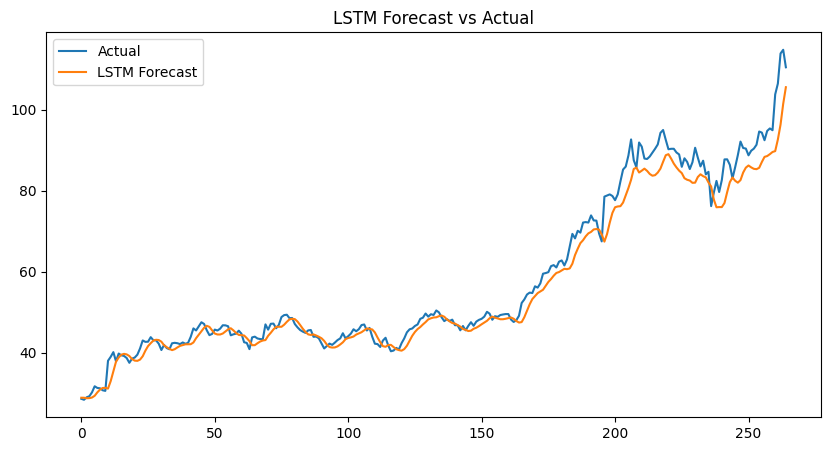

In [11]:
# Plot LSTM Forecast vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(lstm_pred, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()


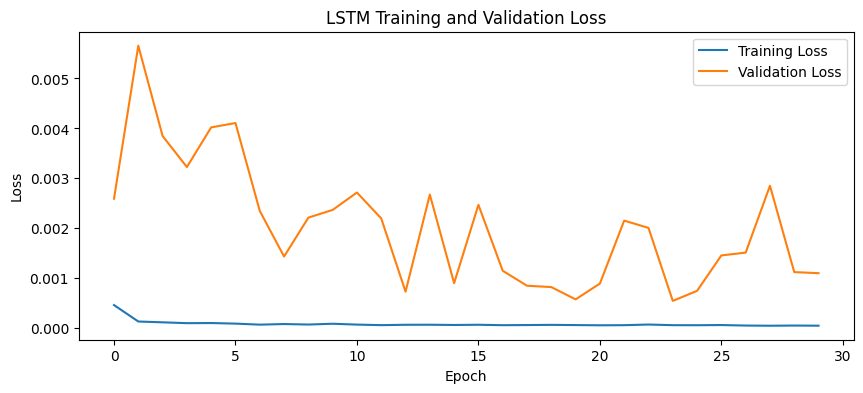

In [12]:
# Plot LSTM Training Loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:

# === Step 8: Evaluation ===
def evaluate_model(true, pred):
    rmse = math.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')


print("\nLSTM Evaluation:")
evaluate_model(y_test_rescaled, lstm_pred)

# === Optional: Save Results ===
df.to_csv("nvidia_stock_data_used.csv")



LSTM Evaluation:
RMSE: 3.80, MAE: 2.62


In [14]:
##Fine tuning
from keras.layers import Bidirectional

# Adjust time step and batch size
X_train, y_train = create_dataset(train, time_step=60)
X_test, y_test = create_dataset(test, time_step=60)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build a deeper Bidirectional LSTM
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(60, 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Bidirectional(LSTM(64)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict and scale back
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - loss: 1.7476e-04 - val_loss: 0.0019
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 1.5467e-04 - val_loss: 0.0029
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 1.3118e-04 - val_loss: 8.1279e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 1.2377e-04 - val_loss: 0.0018
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 9.3991e-05 - val_loss: 9.5298e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 9.3143e-05 - val_loss: 0.0037
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 1.0132e-04 - val_loss: 0.0024
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 1.1169e-04 - val_loss: 7.2317e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 9.1502e-05 - val_loss: 0.0033
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 9.1035e-05 - val_loss: 0.0032
E

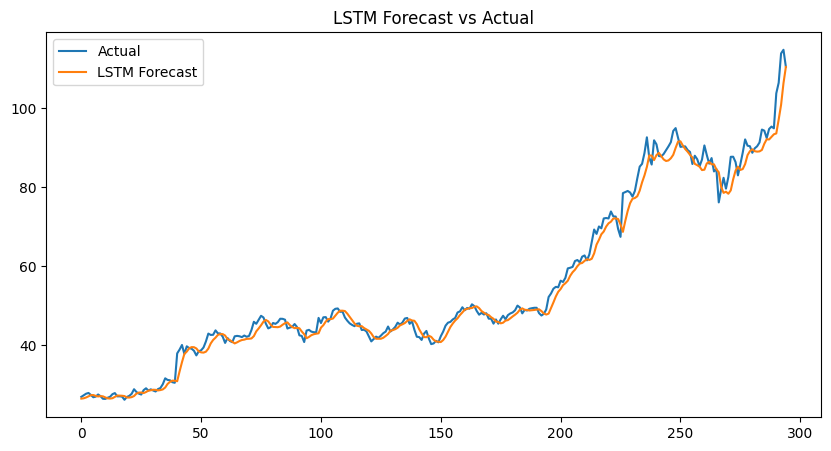

In [15]:
# Plot LSTM Forecast vs Actual
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(lstm_pred, label='LSTM Forecast')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()

In [16]:
##after tuning
print("\nLSTM Evaluation:")
evaluate_model(y_test_rescaled, lstm_pred)


LSTM Evaluation:
RMSE: 2.55, MAE: 1.70
